In [3]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=580d7551323a45a51fe9d20df94f35b3917153bad37655c5309d1c37eb41f519
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=22b3ff2bb84a12c1bec6b468b308d0cb3b5f621f649bc8ef907a4e86e6785779
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

# ****Dataset preparation****

In [5]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp, time
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        im_nii_paths = sorted(glob(f"{root}/Task03_Liver_rs/imagesTr/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/Task03_Liver_rs/labelsTr/*.nii"))
        
        self.ims, self.gts = self.get_slices(im_nii_paths, gt_nii_paths)
        self.transformations = transformations
        self.n_cls = 2
        
        assert len(self.ims) == len(self.gts)
        
    def __len__(self): return len(self.ims)

    def __getitem__(self, idx):
        
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        # For visualization purposes
        im = self.preprocess_im(im)
        # For the cases when label equals to 2; to avoid CE Loss error
        gt[gt > 1] = 1 
        
        return im.float(), gt.unsqueeze(0).long()
        
    def preprocess_im(self, im): 
        
        max_val = 500
        im[im < 0] = 0
        
        return im / max_val
    
    def get_slices(self, im_nii_paths, gt_nii_paths): 
        
        ims, gts = [], []
        
        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            print(f"Nifti file number {index + 1} is being processed...")
            nii_im_data, nii_gt_data  = self.read_nii(im_nii, gt_nii)
            
            for idx, (im, gt) in enumerate(zip(nii_im_data, nii_gt_data)):
                if len(np.unique(gt)) == 2: ims.append(im); gts.append(gt)
        
        return ims, gts

    def read_nii(self, im, gt): return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)
    
    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.6, 0.2, 0.2], ns = 4):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\n In the training dataset there are {len(tr_ds)} images")
    print(f"In the training dataset there are {len(val_ds)} images")
    print(f"In the training dataset there are{len(test_ds)} images\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/kaggle/input/3d-liver-segmentation"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 16)

Nifti file number 1 is being processed...
Nifti file number 2 is being processed...
Nifti file number 3 is being processed...
Nifti file number 4 is being processed...
Nifti file number 5 is being processed...
Nifti file number 6 is being processed...
Nifti file number 7 is being processed...
Nifti file number 8 is being processed...
Nifti file number 9 is being processed...
Nifti file number 10 is being processed...
Nifti file number 11 is being processed...
Nifti file number 12 is being processed...
Nifti file number 13 is being processed...
Nifti file number 14 is being processed...
Nifti file number 15 is being processed...
Nifti file number 16 is being processed...
Nifti file number 17 is being processed...
Nifti file number 18 is being processed...
Nifti file number 19 is being processed...
Nifti file number 20 is being processed...
Nifti file number 21 is being processed...
Nifti file number 22 is being processed...
Nifti file number 23 is being processed...
Nifti file number 24

# **Data Visualization**

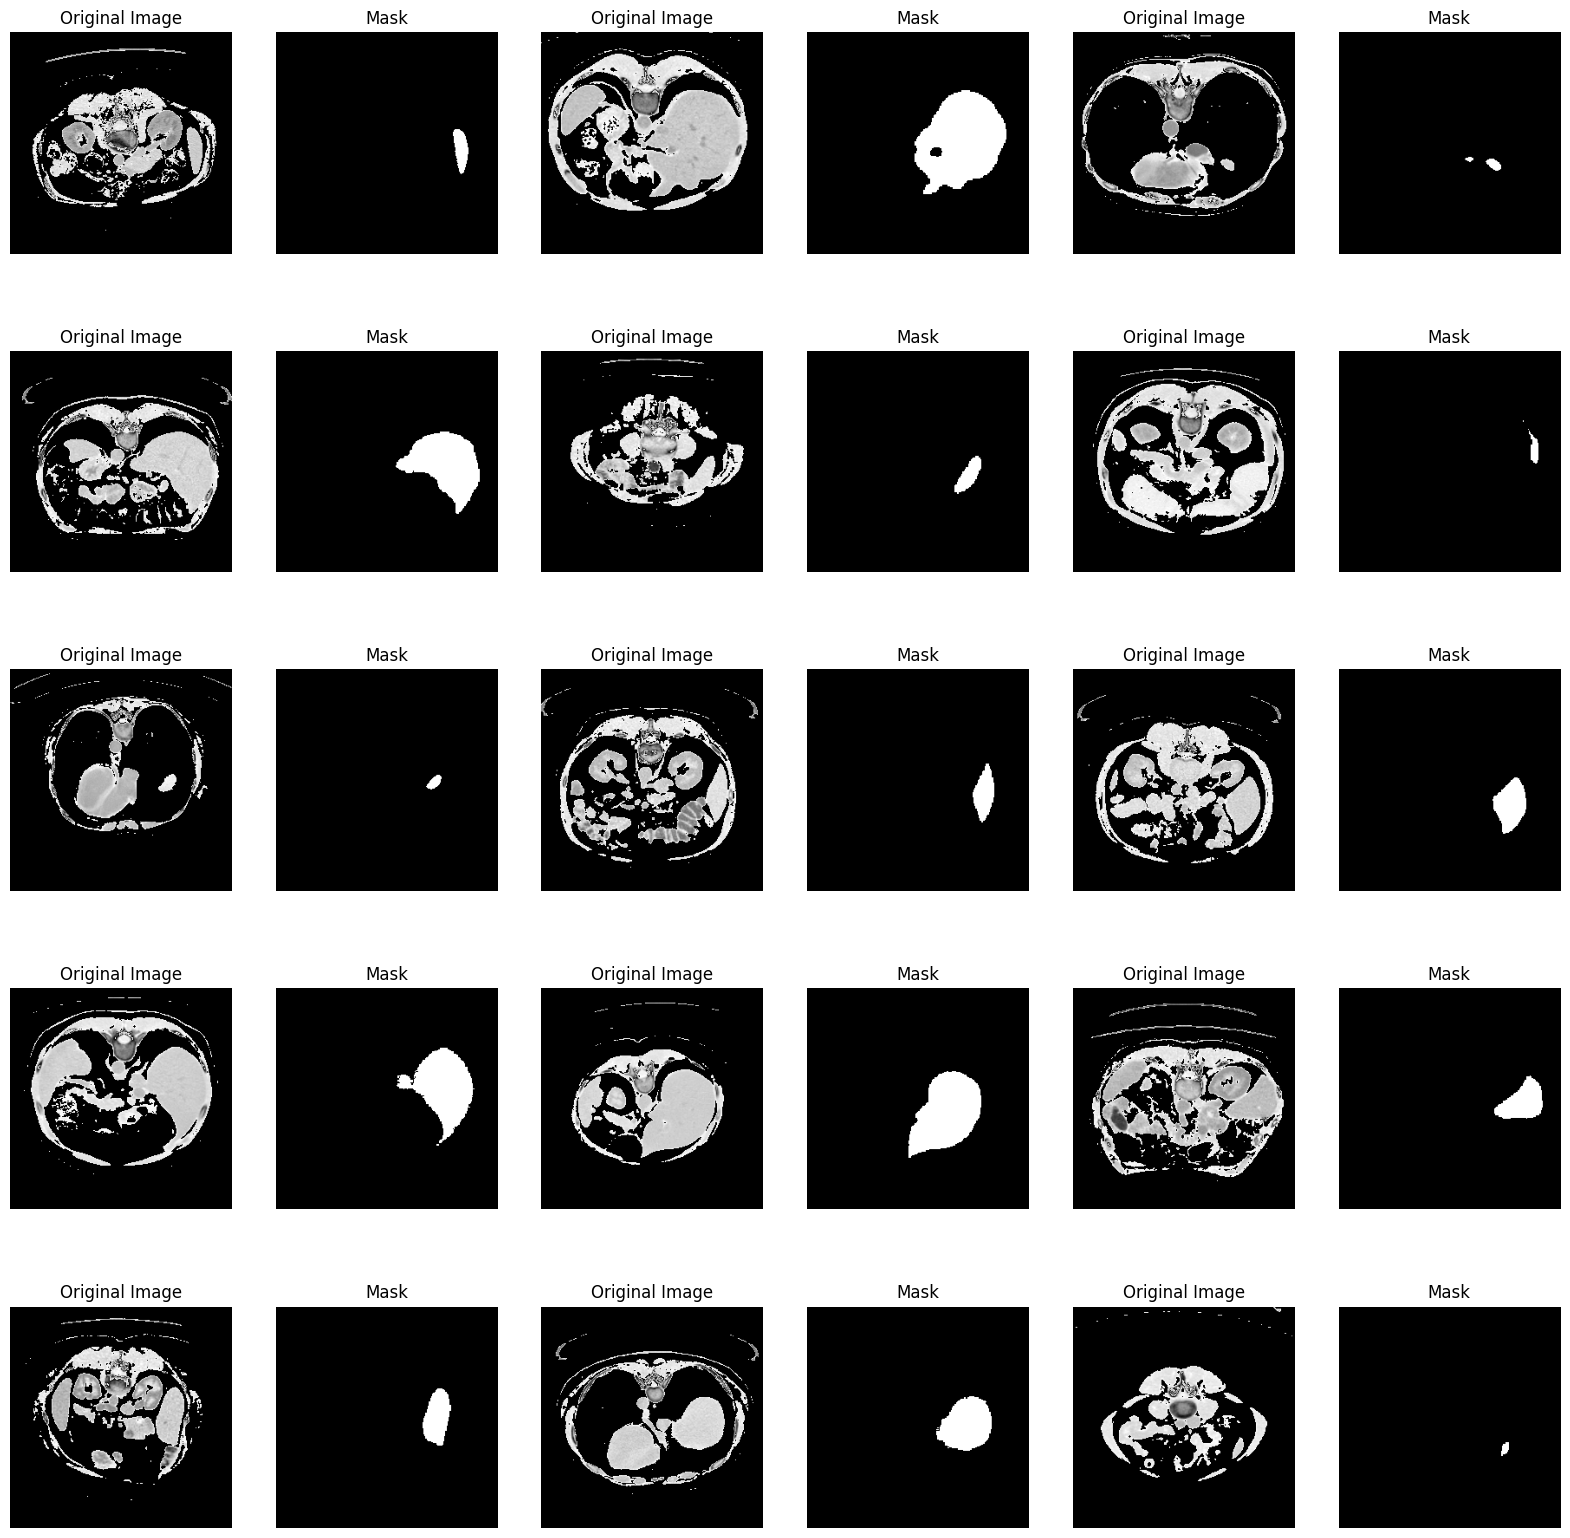

In [6]:
# Functions for visualizing images and their corresponding masks
def plot(rows, cols, count, im, gt=None, title="Original Image"):
     # If gt is not specified, convert the tensor to a grayscale image
    
    plt.subplot(rows, cols, count)
    if gt:
        plt.imshow(im.squeeze(0).float(),cmap='gist_gray') 
        
    else:
       
        im = (im*255).cpu().permute(1, 2, 0).numpy()
        im = im.astype("uint8")*255
        plt.imshow(im,cmap='gist_gray')
    plt.axis("off")
    plt.title(title)
# Update the current position in the grid
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (20, 20))
    rows = n_ims // 6
    cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    
        
        if count == n_ims + 1: break
        
        im, gt = ds[index]
    
        
        count = plot(rows, cols, count, im = im)
        
        
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "Маsk")
        
visualize(tr_dl.dataset, n_ims = 30)

# **Model training and Validation**

In [7]:

models = {
    
    "UnetPlusPlus": smp.UnetPlusPlus(classes=n_cls, in_channels=1),
    "MAnet": smp.MAnet(classes=n_cls, in_channels=1),
    "DeepLabV3Plus": smp.DeepLabV3Plus(classes=n_cls, in_channels=1)
}
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)
lr = 0.001
opts = {
    "UnetPlusPlus": torch.optim.Adam(params=models["UnetPlusPlus"].parameters(), lr=lr),
    "MAnet": torch.optim.Adam(params=models["MAnet"].parameters(),lr=lr),
    "DeepLabV3Plus": torch.optim.Adam(params=models["DeepLabV3Plus"].parameters(),lr=lr)
}
schedulers = {
        "UnetPlusPlus": torch.optim.lr_scheduler.StepLR(opts["UnetPlusPlus"], step_size=40, gamma=0.1),
        "MAnet": torch.optim.lr_scheduler.StepLR(opts["MAnet"], step_size=40, gamma=0.1),
        "DeepLabV3Plus": torch.optim.lr_scheduler.StepLR(opts["DeepLabV3Plus"], step_size=40, gamma=0.1)
    }

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(pred, dim = 1) > 0, gt 
        self.loss_fn, self.eps, self.n_cls, self.pred_, self.device = loss_fn, eps, n_cls, pred, device 
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    
    def pixel_accuracy(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def loss(self): return self.loss_fn(self.pred_, self.gt.squeeze(1))
    
   
    def Jaccard(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            jac_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: jac_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    jac = (intersect + self.eps) / (union + self.eps)
                    jac_per_class.append(jac)
                    
            return np.nanmean(jac_per_class)
        
    def precision(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            tp = torch.sum(torch.logical_and(pred, gt).float()).item()
            fp = torch.sum(torch.logical_and(pred, ~gt).float()).item()
        return tp / (tp + fp + self.eps)

    def recall(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            tp = torch.sum(torch.logical_and(pred, gt).float()).item()
            fn = torch.sum(torch.logical_and(~pred, gt).float()).item()
        return tp / (tp + fn + self.eps)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 212MB/s] 


In [8]:
def train(models, tr_dl, val_dl, loss_fn, opts, device, epochs, save_prefix, threshold=0.005, save_path="saved_models"):
    
    histories = {}
    
    for model_name, model in models.items():
        tr_loss, tr_pa, tr_jaccard, tr_precision, tr_recall = [],[],[],[],[]
        val_loss, val_pa, val_jaccard, val_precision, val_recall = [],[],[],[],[]
        tr_len, val_len = len(tr_dl), len(val_dl)
        best_loss, decrease, not_improve = np.inf, 1, 0
        os.makedirs(os.path.join(save_path, model_name), exist_ok=True)
        
        model.to(device)
        opt = opts[model_name]
        
        for epoch in range(1, epochs + 1):
            tr_loss_, tr_pa_, tr_jaccard_, tr_precision_, tr_recall_ = 0, 0, 0, 0, 0
            
            model.train()
            print(f"Epoch {epoch} for model {model_name}...")
            for idx, batch in enumerate(tqdm(tr_dl)):
                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device).long()

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls=n_cls)
                loss_ = met.loss().requires_grad_()

                tr_pa_ += met.pixel_accuracy()
                tr_loss_ += loss_.item()
                tr_jaccard_ += met.Jaccard()
                tr_precision_ += met.precision() 
                tr_recall_ += met.recall()

                loss_.backward()
                opt.step()
                opt.zero_grad()
                schedulers[model_name].step()
            
            print(f"Epoch {epoch} validation for model {model_name}...")
            model.eval()
            val_loss_, val_pa_,val_jaccard_,val_precision_, val_recall_ = 0, 0, 0, 0, 0

            with torch.no_grad():
                for idx, batch in enumerate(tqdm(val_dl)):

                    ims, gts = batch
                    ims, gts = ims.to(device), gts.to(device)

                    preds = model(ims)

                    met = Metrics(preds, gts, loss_fn, n_cls=n_cls)

                    val_loss_ += met.loss().item()
                    val_pa_ += met.pixel_accuracy()
                    val_jaccard_ += met.Jaccard()
                    val_precision_ += met.precision() 
                    val_recall_ += met.recall()
                    
            print(f"Epoch {epoch} for model {model_name} finished.")

            tr_loss_ /= tr_len
            tr_pa_ /= tr_len
            tr_jaccard_ /= tr_len
            tr_precision_ /= tr_len
            tr_recall_ /= tr_len

            val_loss_ /= val_len
            val_pa_ /= val_len
            val_jaccard_ /= val_len
            val_precision_ /= val_len
            val_recall_ /= val_len

            print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            print(f"\nEpoch {epoch} results for model {model_name}: \n")
            print(f"Train Loss         -> {tr_loss_:.3f}")
            print(f"Train pixel_accuracy           -> {tr_pa_:.3f}")
            print(f"Train jaccard         -> {tr_jaccard_:.3f}")
            print(f"Train precision         -> {tr_precision_:.3f}")
            print(f"Train recall         -> {tr_recall_:.3f}")
            print(f"Validation Loss    -> {val_loss_:.3f}")
            print(f"Validation pixel_accuracy     -> {val_pa_:.3f}")
            print(f"Validation jaccard     -> {val_jaccard_:.3f}")
            print(f"Validation precision    -> {val_precision_:.3f}")
            print(f"Validation recall     -> {val_recall_:.3f}")
            
            tr_loss.append(tr_loss_)
            tr_pa.append(tr_pa_)
            tr_jaccard.append(tr_jaccard_)
            
            val_loss.append(val_loss_)
            val_pa.append(val_pa_)
            val_jaccard.append(val_jaccard_)
            
            tr_precision.append(tr_precision_)
            tr_recall.append(tr_recall_)

            val_precision.append(val_precision_)
            val_recall.append(val_recall_)
            
            if best_loss > (val_loss_ + threshold):
                best_loss = val_loss_
                decrease += 1
                if decrease % 2 == 0:
                    print("Saving the model with the best loss value...")
                    torch.save(model.state_dict(), os.path.join(save_path, model_name, f"{save_prefix}_best_model.pt"))
        
        histories[model_name] = {"tr_loss": tr_loss, "tr_pa": tr_pa,
                                  "val_loss": val_loss, "val_pa": val_pa,
                                "tr_jaccard": tr_jaccard,"val_jaccard": val_jaccard,
                                "tr_precision":tr_precision,"val_precision":val_precision,
                                "tr_recall":tr_recall,"val_recall":val_recall}
    
    return histories

device = "cuda" if torch.cuda.is_available() else "cpu"


history = train(models=models, tr_dl=tr_dl, val_dl=val_dl,
                 loss_fn=loss_fn, opts=opts, device=device,
                 epochs=50, save_prefix="liver")

Epoch 1 for model UnetPlusPlus...


100%|██████████| 160/160 [00:37<00:00,  4.25it/s]


Epoch 1 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.48it/s]


Epoch 1 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 results for model UnetPlusPlus: 

Train Loss         -> 0.056
Train pixel_accuracy           -> 0.929
Train jaccard         -> 0.912
Train precision         -> 0.469
Train recall         -> 0.913
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.942
Saving the model with the best loss value...
Epoch 2 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 2 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.64it/s]


Epoch 2 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.940
Validation precision    -> 0.482
Validation recall     -> 0.950
Epoch 3 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 3 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.69it/s]


Epoch 3 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.484
Validation recall     -> 0.941
Epoch 4 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 4 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.76it/s]


Epoch 4 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.935
Epoch 5 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 5 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.76it/s]


Epoch 5 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.937
Validation precision    -> 0.487
Validation recall     -> 0.925
Epoch 6 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 6 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.80it/s]


Epoch 6 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.947
Epoch 7 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 7 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.69it/s]


Epoch 7 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.942
Epoch 8 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 8 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.81it/s]


Epoch 8 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.942
Epoch 9 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 9 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.57it/s]


Epoch 9 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.944
Epoch 10 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 10 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 10 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.937
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.946
Epoch 11 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 11 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.72it/s]


Epoch 11 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.940
Epoch 12 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 12 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.61it/s]


Epoch 12 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.486
Validation recall     -> 0.933
Epoch 13 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 13 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 13 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.939
Validation precision    -> 0.481
Validation recall     -> 0.952
Epoch 14 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 14 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.78it/s]


Epoch 14 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.937
Train precision         -> 0.482
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.945
Epoch 15 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 15 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.75it/s]


Epoch 15 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.484
Validation recall     -> 0.940
Epoch 16 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 16 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.70it/s]


Epoch 16 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.937
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.936
Validation precision    -> 0.488
Validation recall     -> 0.921
Epoch 17 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 17 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.79it/s]


Epoch 17 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.938
Epoch 18 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 18 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.67it/s]


Epoch 18 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.944
Epoch 19 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 19 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.66it/s]


Epoch 19 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.484
Validation recall     -> 0.941
Epoch 20 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 20 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.73it/s]


Epoch 20 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.945
Epoch 21 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 21 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.77it/s]


Epoch 21 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.484
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.943
Epoch 22 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 22 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.67it/s]


Epoch 22 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.937
Epoch 23 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 23 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.76it/s]


Epoch 23 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.486
Validation recall     -> 0.933
Epoch 24 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 24 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.76it/s]


Epoch 24 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.941
Epoch 25 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 25 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.78it/s]


Epoch 25 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.946
Epoch 26 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 26 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.66it/s]


Epoch 26 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.938
Epoch 27 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 27 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 27 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.945
Epoch 28 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 28 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 28 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.940
Validation precision    -> 0.482
Validation recall     -> 0.950
Epoch 29 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 29 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.73it/s]


Epoch 29 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.484
Validation recall     -> 0.940
Epoch 30 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 30 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 30 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.944
Epoch 31 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 31 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.79it/s]


Epoch 31 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.937
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.486
Validation recall     -> 0.933
Epoch 32 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 32 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.63it/s]


Epoch 32 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.484
Validation recall     -> 0.941
Epoch 33 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 33 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.88it/s]


Epoch 33 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.936
Epoch 34 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 34 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.76it/s]


Epoch 34 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.946
Epoch 35 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 35 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.70it/s]


Epoch 35 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.938
Validation precision    -> 0.486
Validation recall     -> 0.932
Epoch 36 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 36 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.46it/s]


Epoch 36 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.939
Validation precision    -> 0.480
Validation recall     -> 0.954
Epoch 37 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 37 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.76it/s]


Epoch 37 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.946
Epoch 38 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 38 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.63it/s]


Epoch 38 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.943
Epoch 39 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 39 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.71it/s]


Epoch 39 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.937
Train precision         -> 0.482
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.944
Epoch 40 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 40 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.77it/s]


Epoch 40 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.938
Validation precision    -> 0.486
Validation recall     -> 0.931
Epoch 41 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 41 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.72it/s]


Epoch 41 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 results for model UnetPlusPlus: 

Train Loss         -> 0.028
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.939
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.942
Epoch 42 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 42 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 42 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.940
Validation precision    -> 0.482
Validation recall     -> 0.949
Epoch 43 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 43 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.77it/s]


Epoch 43 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.944
Epoch 44 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 44 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.82it/s]


Epoch 44 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.944
Epoch 45 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 45 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.64it/s]


Epoch 45 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.937
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.940
Epoch 46 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.41it/s]


Epoch 46 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.60it/s]


Epoch 46 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.483
Validation recall     -> 0.946
Epoch 47 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 47 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 47 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.935
Epoch 48 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 48 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.74it/s]


Epoch 48 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.942
Epoch 49 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 49 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.71it/s]


Epoch 49 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.943
Validation Loss    -> 0.028
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.940
Validation precision    -> 0.484
Validation recall     -> 0.942
Epoch 50 for model UnetPlusPlus...


100%|██████████| 160/160 [00:36<00:00,  4.42it/s]


Epoch 50 validation for model UnetPlusPlus...


100%|██████████| 54/54 [00:04<00:00, 11.70it/s]


Epoch 50 for model UnetPlusPlus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 results for model UnetPlusPlus: 

Train Loss         -> 0.029
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.938
Train precision         -> 0.483
Train recall         -> 0.942
Validation Loss    -> 0.029
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.939
Validation precision    -> 0.485
Validation recall     -> 0.938
Epoch 1 for model MAnet...


100%|██████████| 160/160 [00:21<00:00,  7.61it/s]


Epoch 1 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.08it/s]


Epoch 1 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 results for model MAnet: 

Train Loss         -> 0.059
Train pixel_accuracy           -> 0.929
Train jaccard         -> 0.897
Train precision         -> 0.464
Train recall         -> 0.890
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.916
Saving the model with the best loss value...
Epoch 2 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 2 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.55it/s]


Epoch 2 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.924
Epoch 3 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 3 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.70it/s]


Epoch 3 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.914
Epoch 4 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 4 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.71it/s]


Epoch 4 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.913
Epoch 5 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.69it/s]


Epoch 5 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.24it/s]


Epoch 5 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.915
Epoch 6 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 6 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.88it/s]


Epoch 6 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.926
Epoch 7 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 7 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.58it/s]


Epoch 7 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.923
Validation precision    -> 0.482
Validation recall     -> 0.914
Epoch 8 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 8 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.85it/s]


Epoch 8 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.479
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.923
Validation precision    -> 0.483
Validation recall     -> 0.911
Epoch 9 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 9 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 18.96it/s]


Epoch 9 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.914
Epoch 10 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 10 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.64it/s]


Epoch 10 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.926
Epoch 11 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 11 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.74it/s]


Epoch 11 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.481
Validation recall     -> 0.921
Epoch 12 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 12 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.57it/s]


Epoch 12 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.928
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.917
Epoch 13 for model MAnet...


 46%|████▋     | 74/160 [00:09<00:11,  7.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 20 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.86it/s]


Epoch 20 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.482
Validation recall     -> 0.919
Epoch 21 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 21 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.50it/s]


Epoch 21 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.926
Validation precision    -> 0.480
Validation recall     -> 0.927
Epoch 22 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.69it/s]


Epoch 22 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.68it/s]


Epoch 22 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.923
Validation precision    -> 0.483
Validation recall     -> 0.909
Epoch 23 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 23 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.57it/s]


Epoch 23 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.915
Epoch 24 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 24 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.71it/s]


Epoch 24 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.925
Validation precision    -> 0.478
Validation recall     -> 0.932
Epoch 25 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 25 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.81it/s]


Epoch 25 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.479
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.917
Epoch 26 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 26 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.60it/s]


Epoch 26 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.913
Epoch 27 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 27 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.63it/s]


Epoch 27 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.926
Epoch 28 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 28 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.78it/s]


Epoch 28 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.926
Validation precision    -> 0.480
Validation recall     -> 0.928
Epoch 29 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 29 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.69it/s]


Epoch 29 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.930
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.923
Validation precision    -> 0.483
Validation recall     -> 0.912
Epoch 30 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.72it/s]


Epoch 30 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.65it/s]


Epoch 30 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.927
Epoch 31 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.72it/s]


Epoch 31 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.55it/s]


Epoch 31 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.926
Validation precision    -> 0.479
Validation recall     -> 0.930
Epoch 32 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 32 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.61it/s]


Epoch 32 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.482
Validation recall     -> 0.919
Epoch 33 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 33 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.77it/s]


Epoch 33 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.916
Epoch 34 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 34 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.65it/s]


Epoch 34 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.923
Validation precision    -> 0.484
Validation recall     -> 0.908
Epoch 35 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.72it/s]


Epoch 35 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.53it/s]


Epoch 35 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.481
Validation recall     -> 0.921
Epoch 36 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 36 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.72it/s]


Epoch 36 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.034
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.922
Validation precision    -> 0.484
Validation recall     -> 0.904
Epoch 37 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.72it/s]


Epoch 37 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.63it/s]


Epoch 37 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.481
Validation recall     -> 0.920
Epoch 38 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 38 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.73it/s]


Epoch 38 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.926
Validation precision    -> 0.479
Validation recall     -> 0.931
Epoch 39 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 39 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.48it/s]


Epoch 39 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.923
Validation precision    -> 0.483
Validation recall     -> 0.909
Epoch 40 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 40 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.65it/s]


Epoch 40 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.926
Validation precision    -> 0.478
Validation recall     -> 0.935
Epoch 41 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.72it/s]


Epoch 41 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.74it/s]


Epoch 41 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.926
Epoch 42 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.70it/s]


Epoch 42 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.57it/s]


Epoch 42 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.479
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.930
Validation jaccard     -> 0.925
Validation precision    -> 0.478
Validation recall     -> 0.935
Epoch 43 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 43 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.67it/s]


Epoch 43 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.915
Epoch 44 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 44 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.46it/s]


Epoch 44 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.479
Validation recall     -> 0.929
Epoch 45 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 45 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.79it/s]


Epoch 45 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.926
Epoch 46 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 46 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.74it/s]


Epoch 46 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.928
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.479
Validation recall     -> 0.928
Epoch 47 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 47 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.65it/s]


Epoch 47 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.479
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.480
Validation recall     -> 0.928
Epoch 48 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 48 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.87it/s]


Epoch 48 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 results for model MAnet: 

Train Loss         -> 0.033
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.926
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.479
Validation recall     -> 0.930
Epoch 49 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.72it/s]


Epoch 49 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.51it/s]


Epoch 49 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.929
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.924
Validation precision    -> 0.482
Validation recall     -> 0.916
Epoch 50 for model MAnet...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


Epoch 50 validation for model MAnet...


100%|██████████| 54/54 [00:02<00:00, 19.48it/s]


Epoch 50 for model MAnet finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 results for model MAnet: 

Train Loss         -> 0.032
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.927
Train precision         -> 0.480
Train recall         -> 0.930
Validation Loss    -> 0.033
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.925
Validation precision    -> 0.481
Validation recall     -> 0.923
Epoch 1 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.37it/s]


Epoch 1 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.70it/s]


Epoch 1 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 results for model DeepLabV3Plus: 

Train Loss         -> 0.050
Train pixel_accuracy           -> 0.927
Train jaccard         -> 0.907
Train precision         -> 0.473
Train recall         -> 0.903
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.909
Saving the model with the best loss value...
Epoch 2 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 2 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Epoch 2 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.486
Validation recall     -> 0.911
Epoch 3 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 3 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Epoch 3 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.930
Validation precision    -> 0.484
Validation recall     -> 0.922
Epoch 4 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 4 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.63it/s]


Epoch 4 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.905
Epoch 5 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 5 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.73it/s]


Epoch 5 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.912
Epoch 6 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 6 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Epoch 6 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.914
Epoch 7 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 7 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.22it/s]


Epoch 7 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.915
Epoch 8 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 8 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Epoch 8 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.908
Epoch 9 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 9 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.56it/s]


Epoch 9 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.930
Validation precision    -> 0.485
Validation recall     -> 0.917
Epoch 10 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 10 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.70it/s]


Epoch 10 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.909
Epoch 11 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 11 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Epoch 11 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.916
Epoch 12 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 12 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.24it/s]


Epoch 12 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.930
Validation precision    -> 0.485
Validation recall     -> 0.918
Epoch 13 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 13 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.80it/s]


Epoch 13 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.929
Validation precision    -> 0.484
Validation recall     -> 0.919
Epoch 14 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 14 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Epoch 14 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.486
Validation recall     -> 0.913
Epoch 15 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 15 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Epoch 15 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.929
Train precision         -> 0.483
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.911
Epoch 16 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 16 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Epoch 16 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.916
Epoch 17 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 17 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Epoch 17 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.921
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.903
Epoch 18 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 18 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Epoch 18 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.903
Epoch 19 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 19 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Epoch 19 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.486
Validation recall     -> 0.913
Epoch 20 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 20 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.82it/s]


Epoch 20 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.903
Epoch 21 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 21 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.40it/s]


Epoch 21 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.907
Epoch 22 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 22 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.48it/s]


Epoch 22 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.932
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.906
Epoch 23 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.41it/s]


Epoch 23 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Epoch 23 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.485
Validation recall     -> 0.914
Epoch 24 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.38it/s]


Epoch 24 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Epoch 24 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.483
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.916
Epoch 25 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 25 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Epoch 25 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.914
Epoch 26 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 26 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Epoch 26 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.904
Epoch 27 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 27 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.42it/s]


Epoch 27 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.930
Validation precision    -> 0.485
Validation recall     -> 0.919
Epoch 28 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 28 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.64it/s]


Epoch 28 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.486
Validation recall     -> 0.913
Epoch 29 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 29 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.54it/s]


Epoch 29 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.926
Validation precision    -> 0.487
Validation recall     -> 0.901
Epoch 30 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 30 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.42it/s]


Epoch 30 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.487
Validation recall     -> 0.907
Epoch 31 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 31 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Epoch 31 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.909
Epoch 32 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 32 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Epoch 32 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.921
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.908
Epoch 33 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 33 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Epoch 33 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.914
Epoch 34 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.38it/s]


Epoch 34 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.47it/s]


Epoch 34 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.921
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.927
Validation precision    -> 0.487
Validation recall     -> 0.905
Epoch 35 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 35 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.31it/s]


Epoch 35 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.916
Epoch 36 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 36 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.44it/s]


Epoch 36 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.915
Epoch 37 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 37 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.50it/s]


Epoch 37 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.916
Epoch 38 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 38 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Epoch 38 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.926
Validation precision    -> 0.487
Validation recall     -> 0.902
Epoch 39 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 39 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.67it/s]


Epoch 39 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.911
Epoch 40 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 40 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.28it/s]


Epoch 40 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.911
Epoch 41 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 41 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Epoch 41 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.930
Validation precision    -> 0.484
Validation recall     -> 0.920
Epoch 42 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 42 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.66it/s]


Epoch 42 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.911
Epoch 43 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 43 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.45it/s]


Epoch 43 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.915
Epoch 44 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.38it/s]


Epoch 44 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.11it/s]


Epoch 44 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.914
Epoch 45 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 45 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.56it/s]


Epoch 45 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.923
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.928
Validation precision    -> 0.486
Validation recall     -> 0.911
Epoch 46 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 46 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Epoch 46 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.926
Validation precision    -> 0.488
Validation recall     -> 0.898
Epoch 47 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 47 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.64it/s]


Epoch 47 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.486
Validation recall     -> 0.912
Epoch 48 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 48 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Epoch 48 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.483
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.929
Validation precision    -> 0.485
Validation recall     -> 0.914
Epoch 49 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.40it/s]


Epoch 49 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.22it/s]


Epoch 49 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.931
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.931
Validation jaccard     -> 0.931
Validation precision    -> 0.483
Validation recall     -> 0.925
Epoch 50 for model DeepLabV3Plus...


100%|██████████| 160/160 [00:21<00:00,  7.39it/s]


Epoch 50 validation for model DeepLabV3Plus...


100%|██████████| 54/54 [00:03<00:00, 17.58it/s]

Epoch 50 for model DeepLabV3Plus finished.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 results for model DeepLabV3Plus: 

Train Loss         -> 0.025
Train pixel_accuracy           -> 0.933
Train jaccard         -> 0.930
Train precision         -> 0.484
Train recall         -> 0.922
Validation Loss    -> 0.025
Validation pixel_accuracy     -> 0.932
Validation jaccard     -> 0.925
Validation precision    -> 0.488
Validation recall     -> 0.897


# **Charts and Plots**

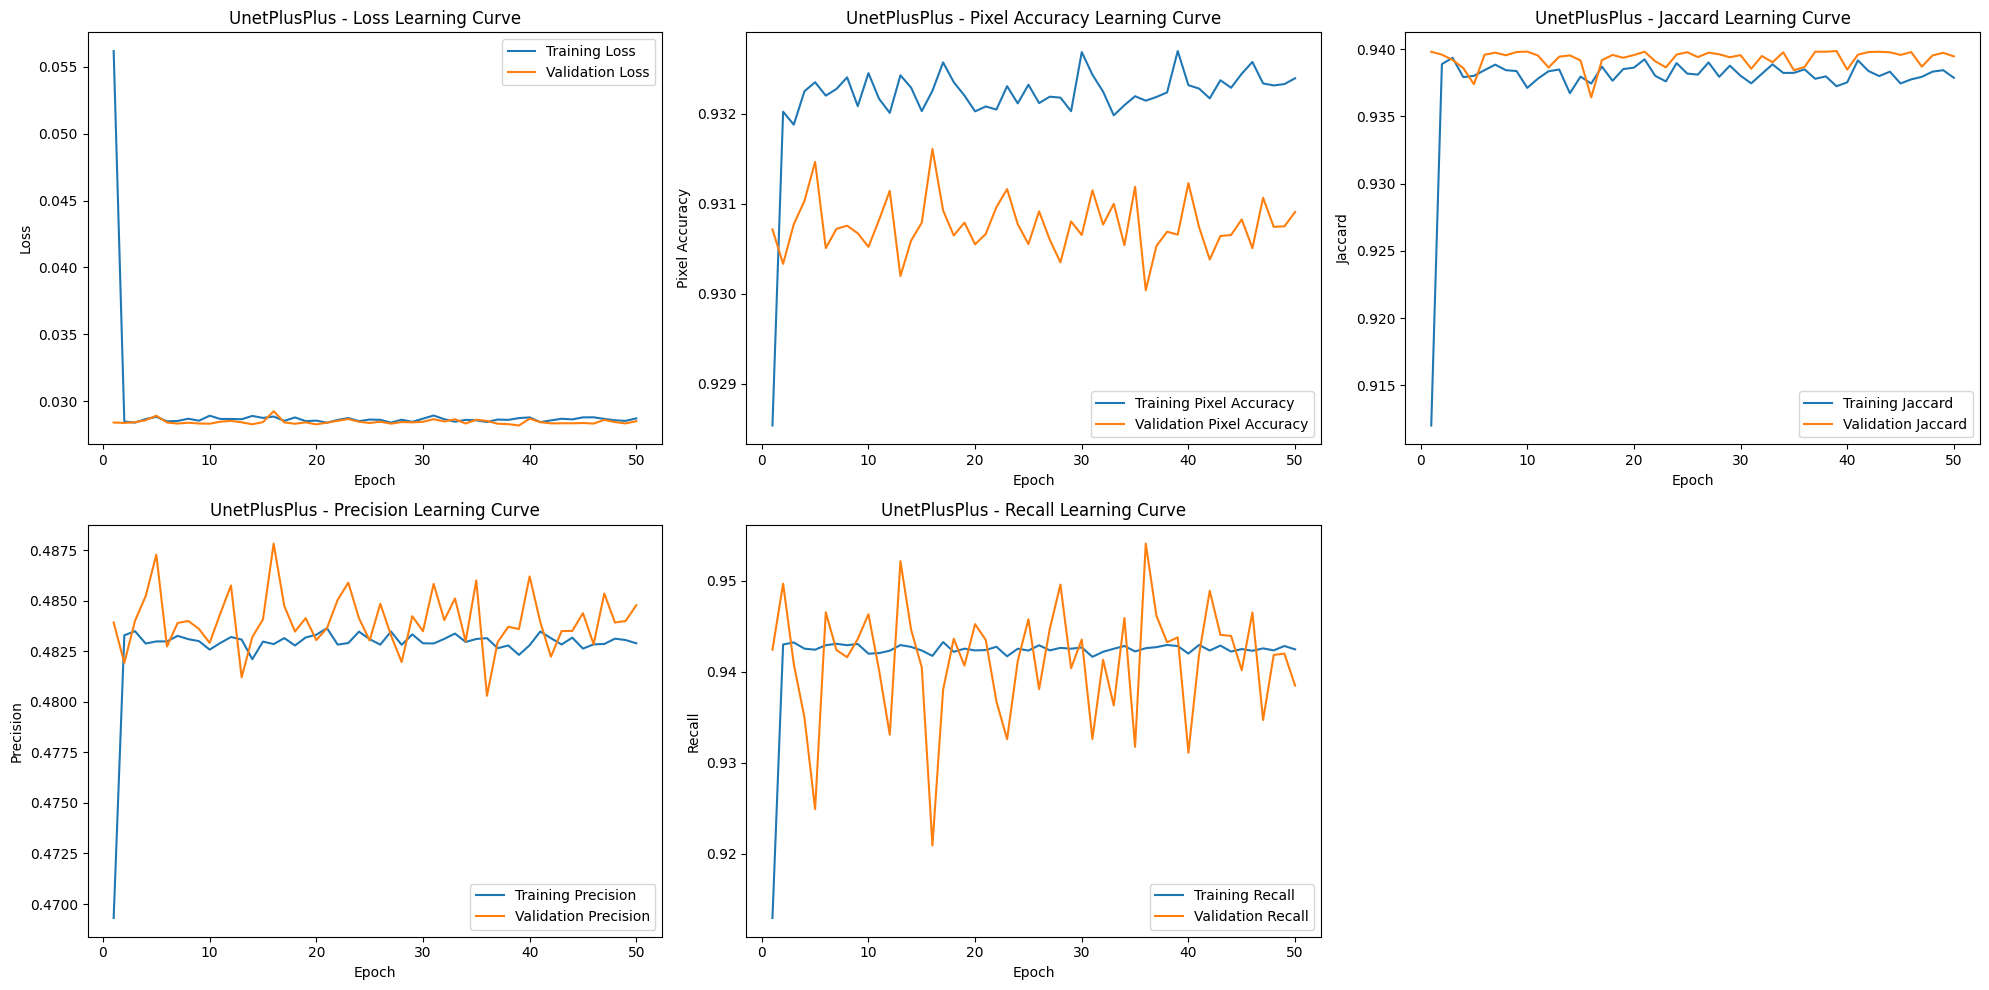

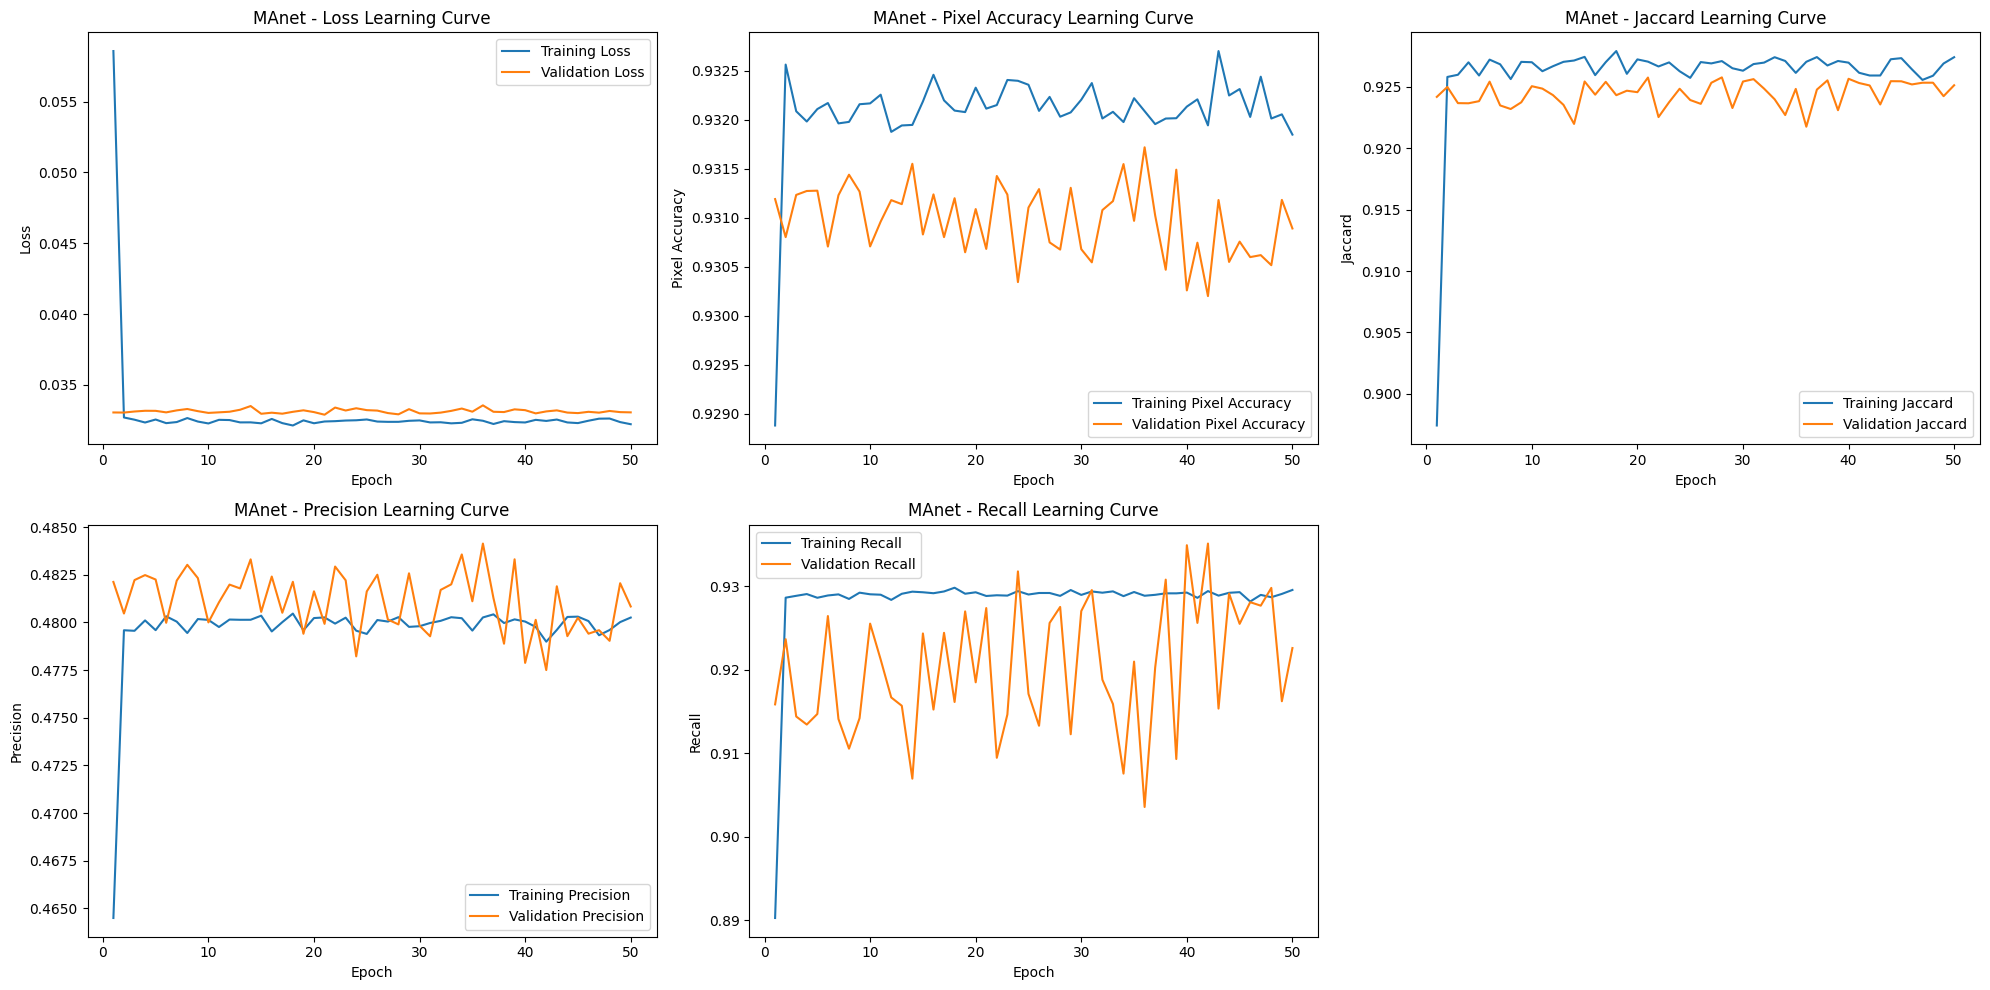

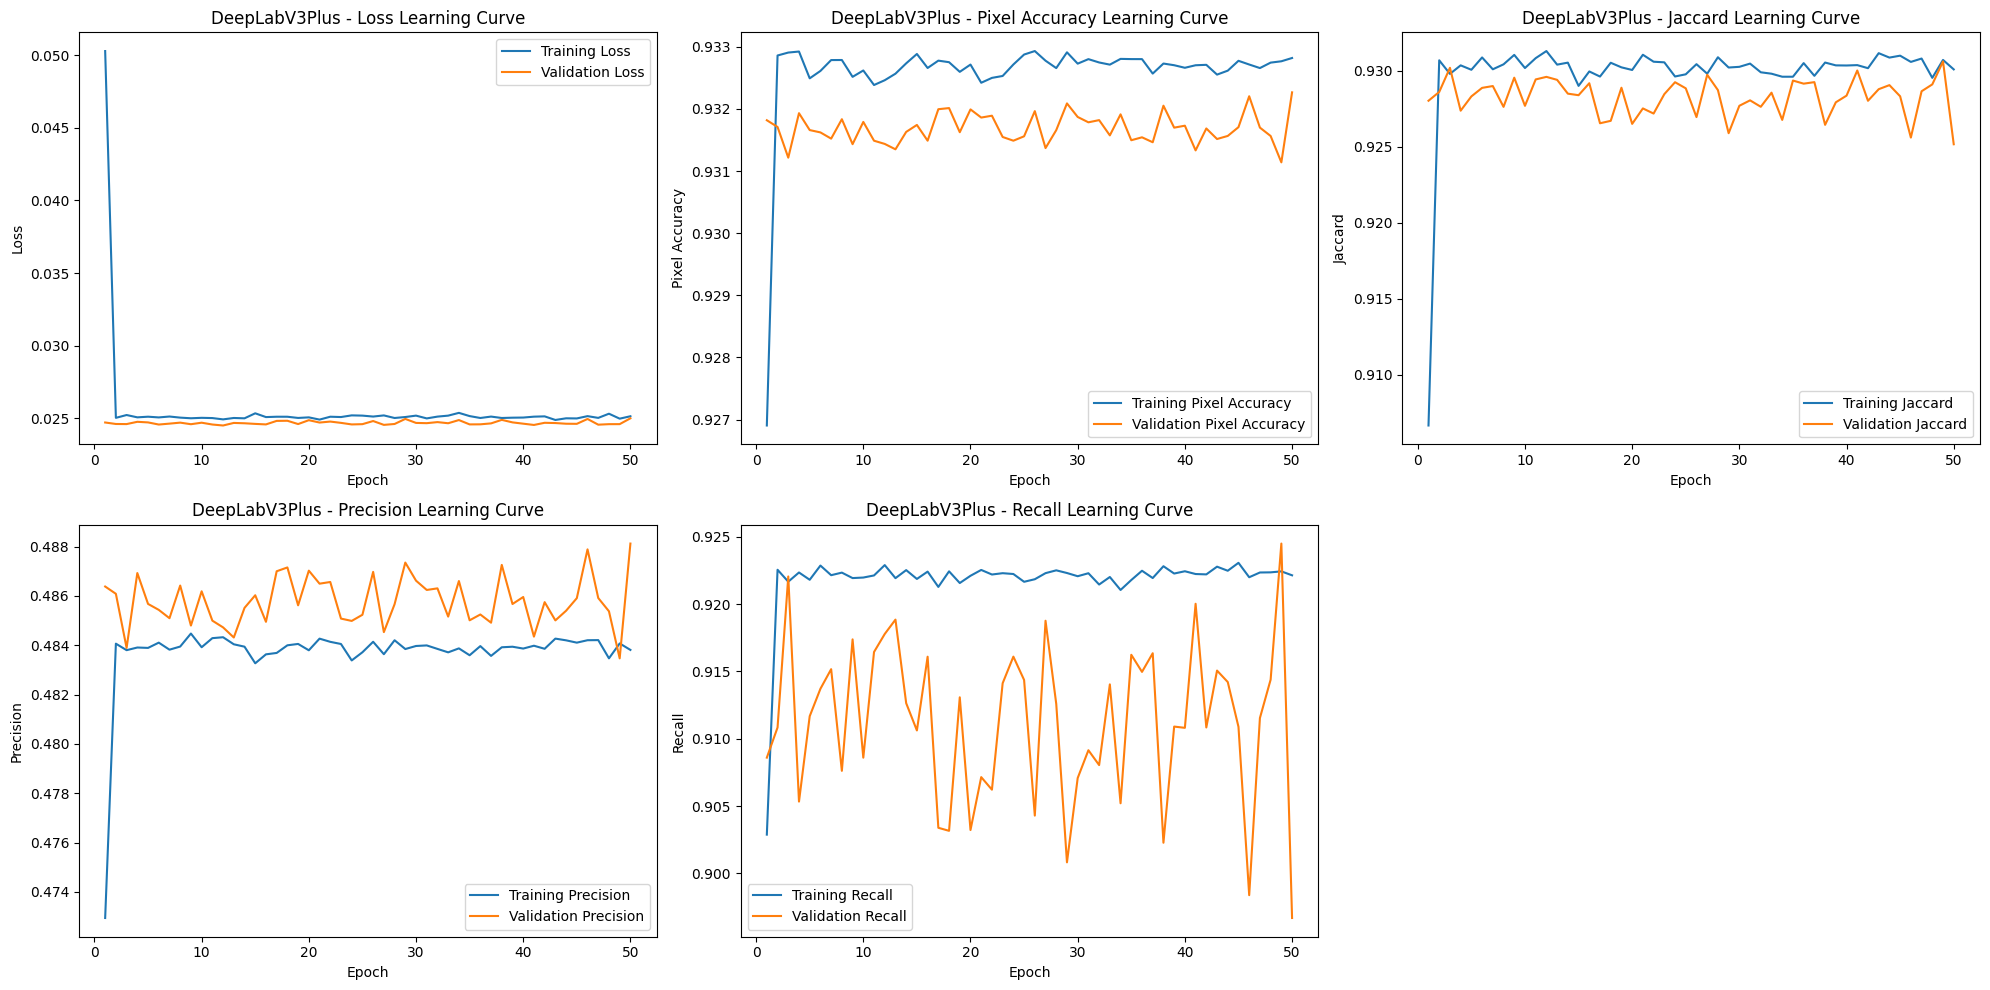

In [9]:
def plot_learning_curves(history):
    for model_name, model_history in history.items():
        epochs = range(1, len(model_history['tr_loss']) + 1)

        plt.figure(figsize=(20, 10))

        # Plotting the loss curve
        plt.subplot(2, 3, 1)
        plt.plot(epochs, model_history['tr_loss'], label='Training Loss')
        plt.plot(epochs, model_history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} - Loss Learning Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting the pixel accuracy curve
        plt.subplot(2, 3, 2)
        plt.plot(epochs, model_history['tr_pa'], label='Training Pixel Accuracy')
        plt.plot(epochs, model_history['val_pa'], label='Validation Pixel Accuracy')
        plt.title(f'{model_name} - Pixel Accuracy Learning Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Pixel Accuracy')
        plt.legend()

        # Plotting the Jaccard curve
        plt.subplot(2, 3, 3)
        plt.plot(epochs, model_history['tr_jaccard'], label='Training Jaccard')
        plt.plot(epochs, model_history['val_jaccard'], label='Validation Jaccard')
        plt.title(f'{model_name} - Jaccard Learning Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Jaccard')
        plt.legend()

        # Plotting the precision curve
        plt.subplot(2, 3, 4)
        plt.plot(epochs, model_history['tr_precision'], label='Training Precision')
        plt.plot(epochs, model_history['val_precision'], label='Validation Precision')
        plt.title(f'{model_name} - Precision Learning Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()

        # Plotting the recall curve
        plt.subplot(2, 3, 5)
        plt.plot(epochs, model_history['tr_recall'], label='Training Recall')
        plt.plot(epochs, model_history['val_recall'], label='Validation Recall')
        plt.title(f'{model_name} - Recall Learning Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plotting learning curves
plot_learning_curves(history)


# **Conclusion**

In [10]:
def inference(dl, model, device, n_ims = 12):
    
    cols = n_ims // 3
    rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get the predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im)
        gts.append(gt)
        preds.append(pred)
        
    plt.figure(figsize = (20, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols:
            break
        # Original image
        count = plot(cols, rows, count, im.squeeze(0))

        # Ground truth
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Predicted mask
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")


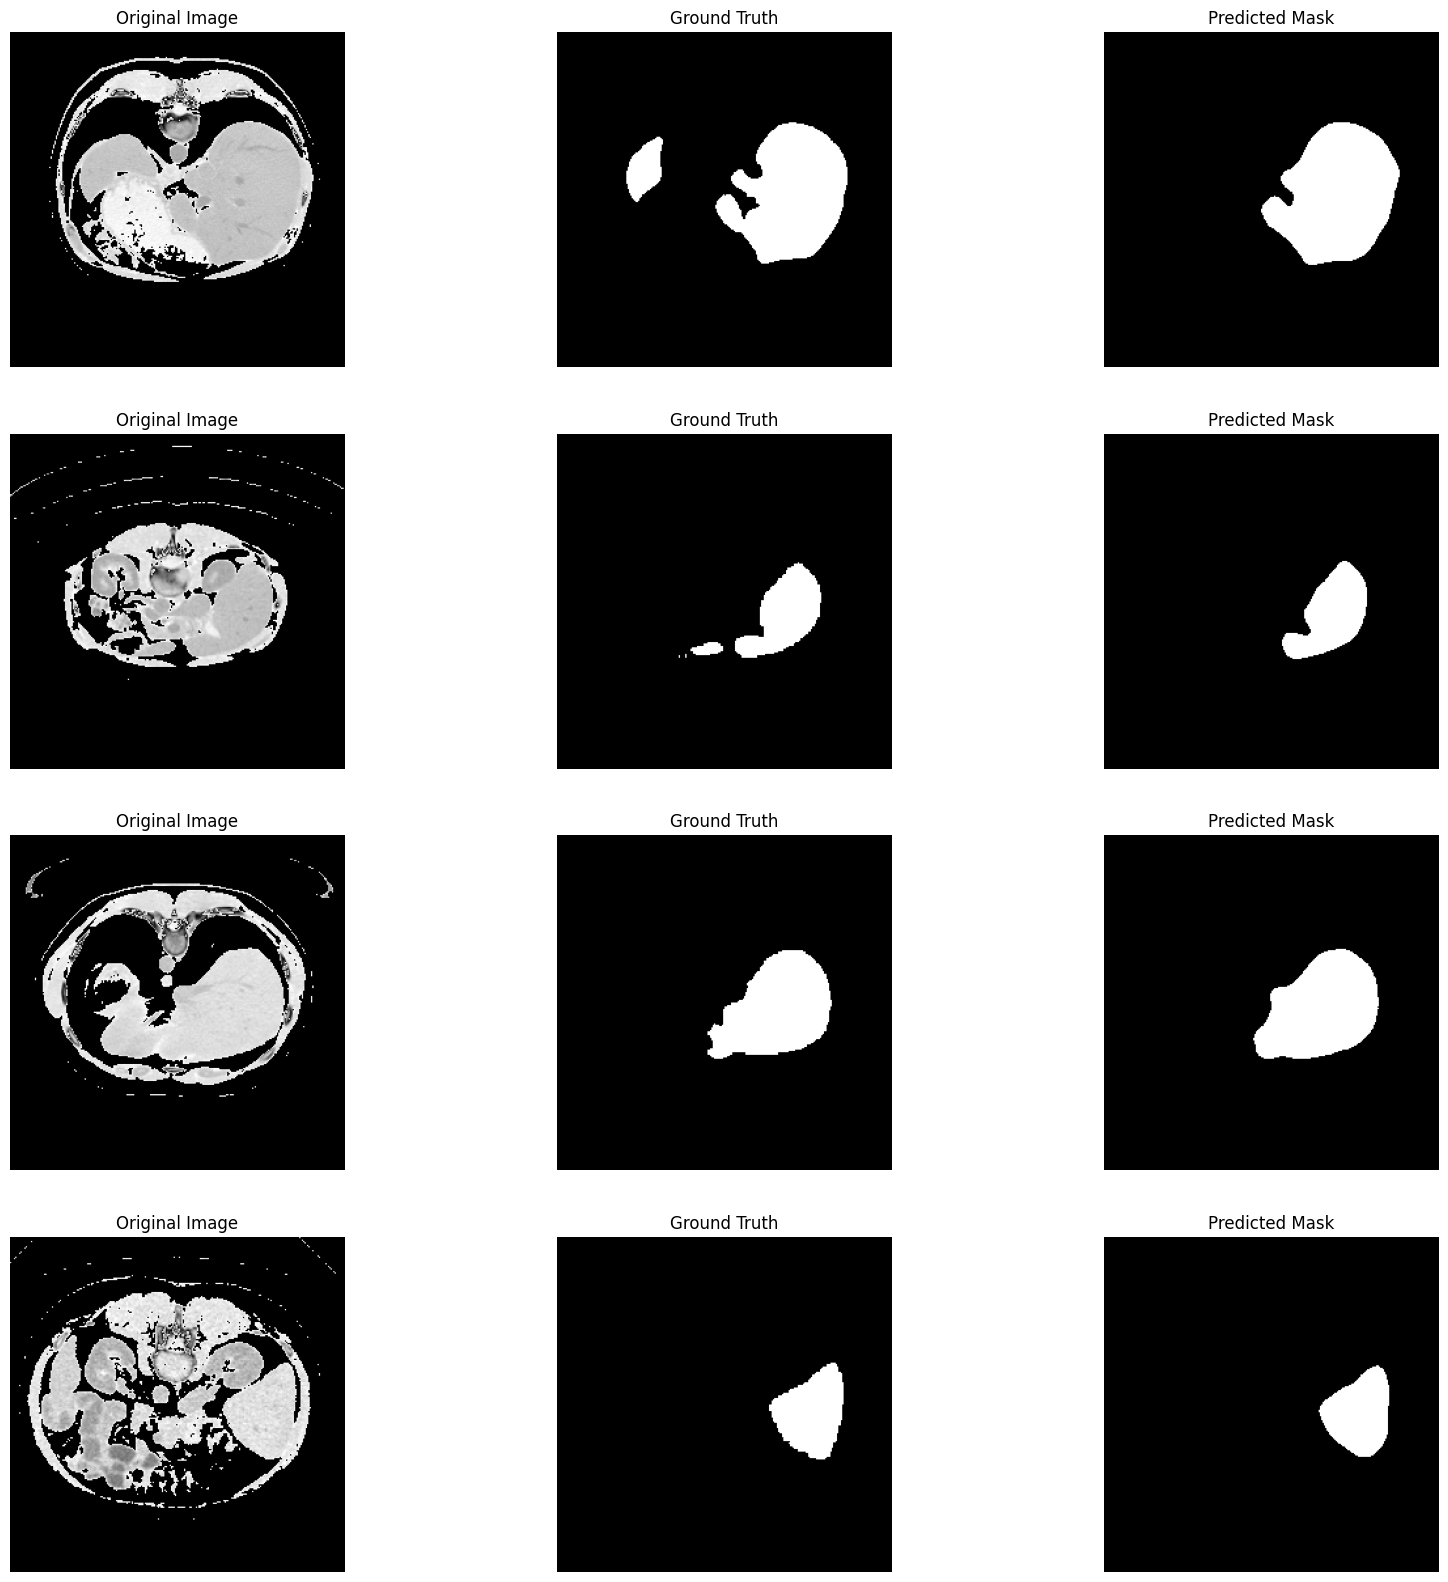

In [11]:
# Initialize the model (ensure that the model architecture is the same as during saving)
model = smp.UnetPlusPlus(classes=n_cls, in_channels=1) 
model.to(device)
# Load the saved state_dict
state_dict = torch.load("saved_models/UnetPlusPlus/liver_best_model.pt", map_location=device)

# Load the state_dict into the model
model.load_state_dict(state_dict)

# Turn off the training mode
model.eval()

# Perform inference
inference(test_dl, model=model, device=device)


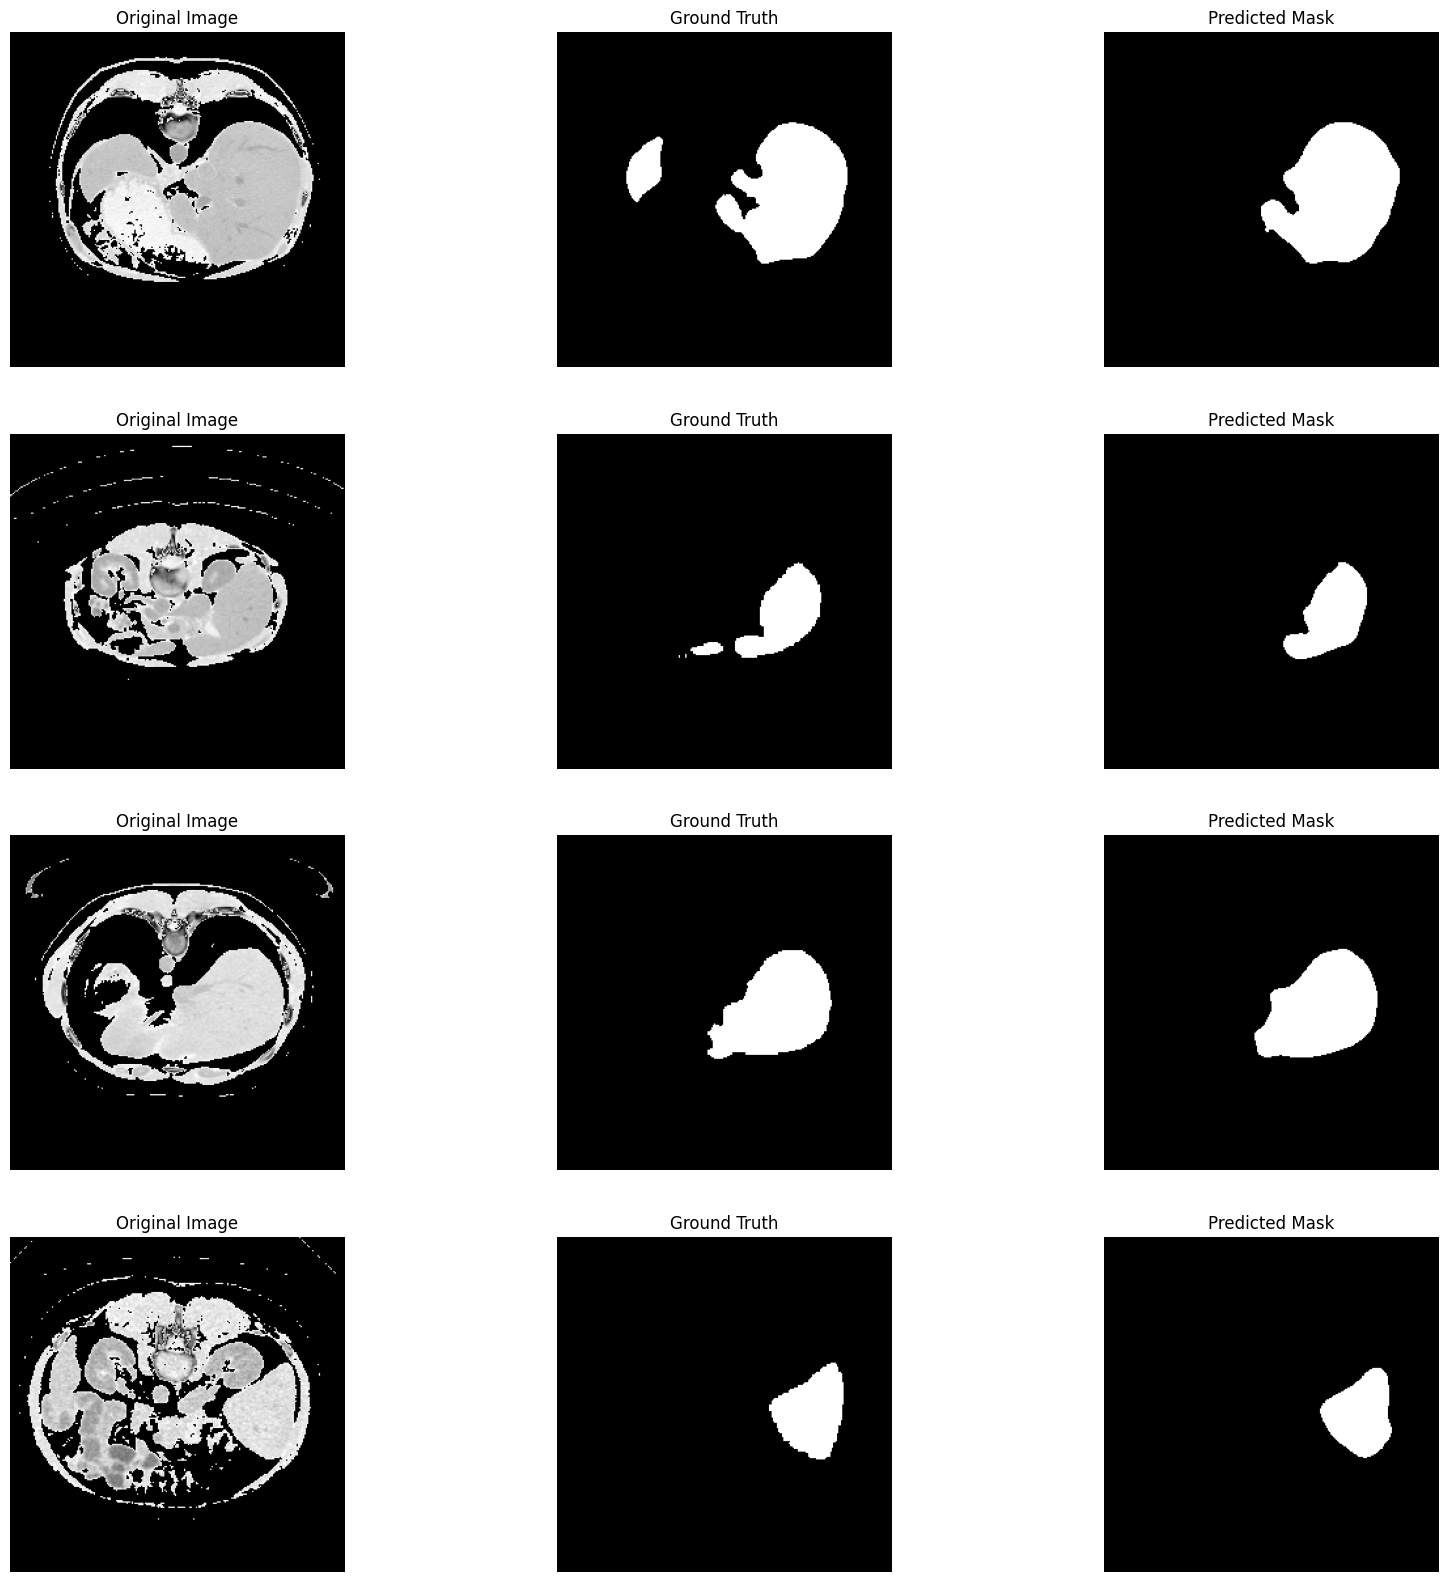

In [12]:
# Initialize the device (make sure the model architecture is the same as during saving)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
model = smp.MAnet(classes=n_cls, in_channels=1) 
model.to(device)
# Load the saved state_dict
state_dict = torch.load("saved_models/MAnet/liver_best_model.pt", map_location=device)

# Load the state_dict into the model
model.load_state_dict(state_dict)

# Turn off the training mode
model.eval()

# Perform inference
inference(test_dl, model=model, device=device)


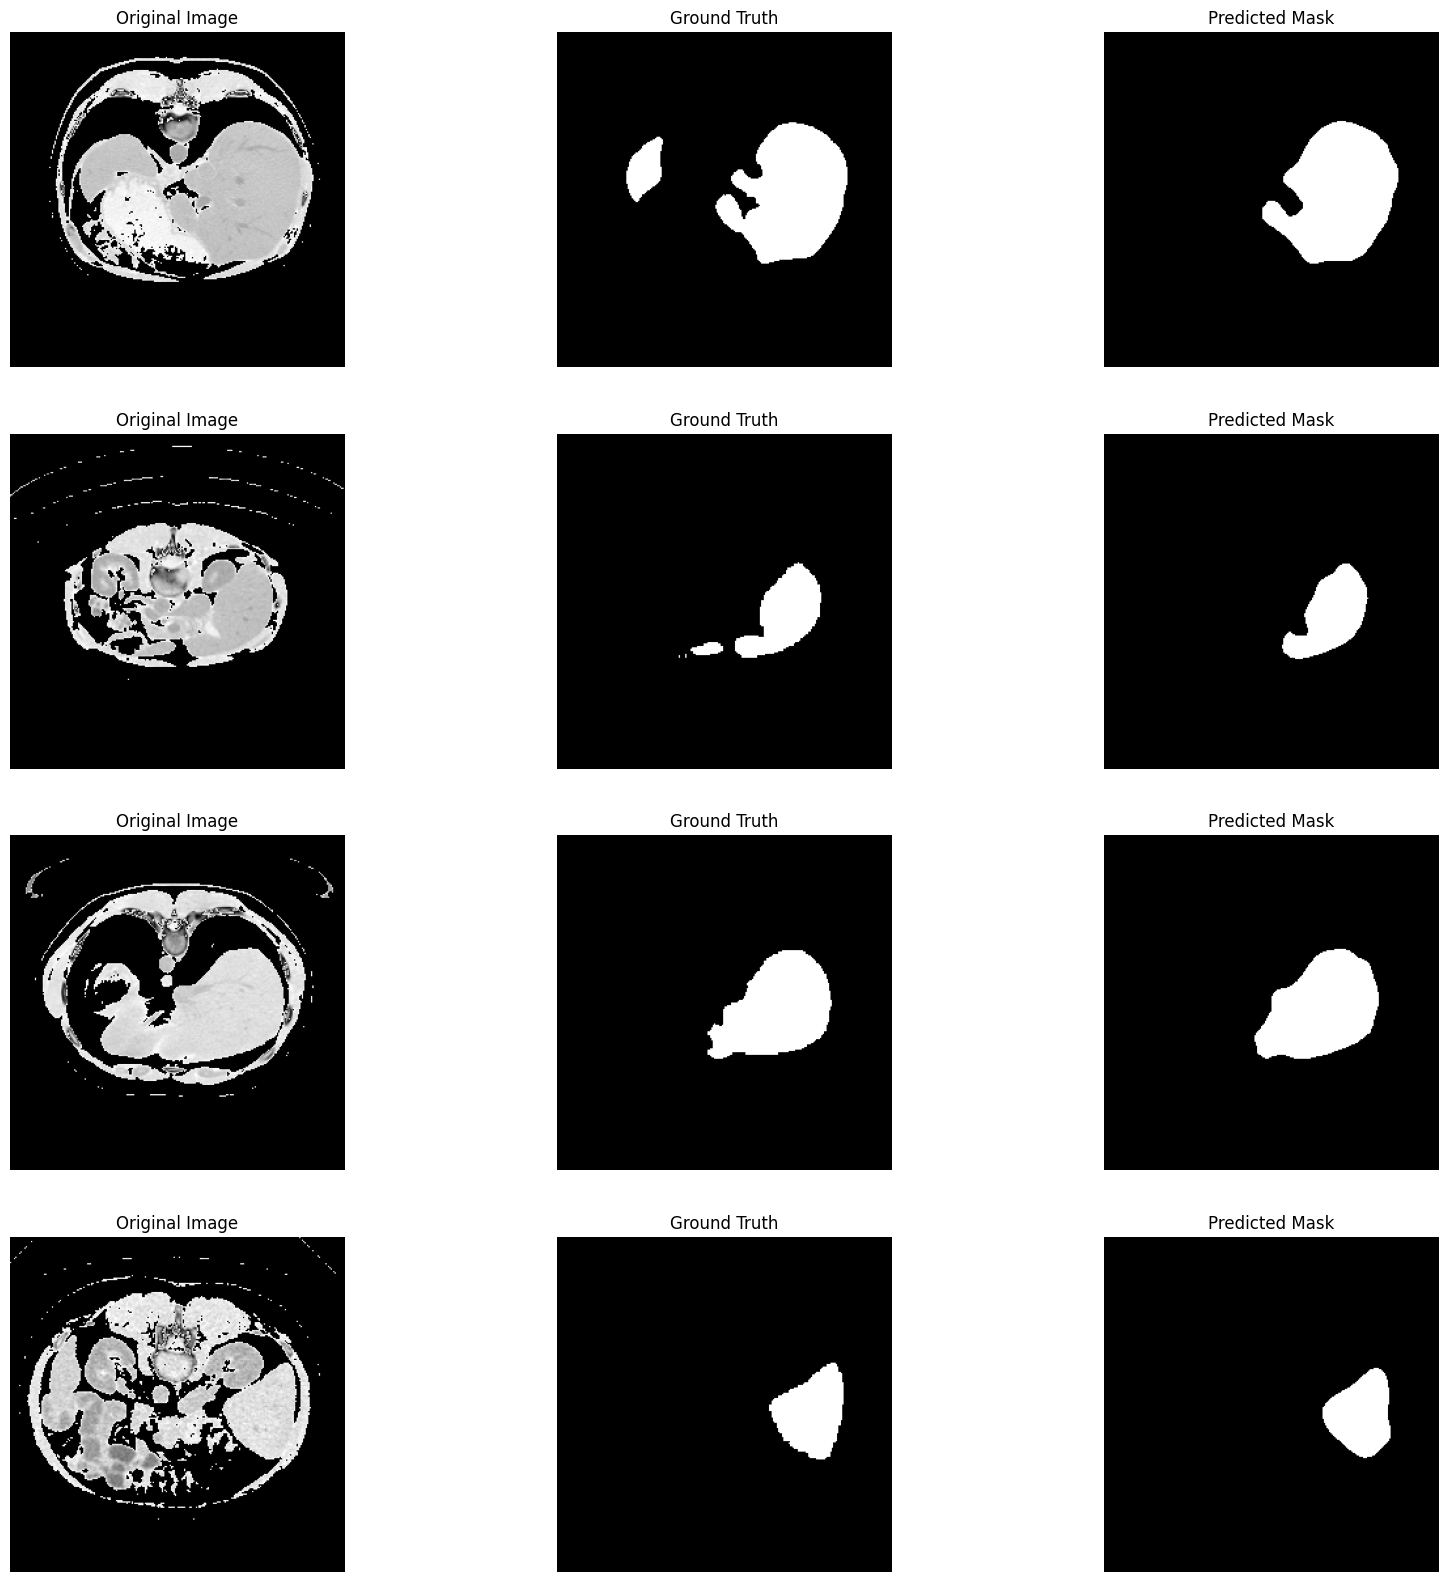

In [13]:
# Initialize the model (ensure that the model architecture is the same as during saving)
model = smp.DeepLabV3Plus(classes=n_cls, in_channels=1) 
model.to(device)
# Load the saved state_dict
state_dict = torch.load("saved_models/DeepLabV3Plus/liver_best_model.pt", map_location=device)

# Load the state_dict into the model
model.load_state_dict(state_dict)

# Turn off the training mode
model.eval()

# Perform inference
inference(test_dl, model=model, device=device)
